In [ ]:
class DataExtractor:
    def __init__(self, client_id, token):
        self.headers = {
            'Client-ID': client_id,
            'Authorization': f'Bearer {token}'
        }

    def extract(self, endpoints_columnas: dict, show_logs=True, keep_logs=False,
                save_path='data', nombre_archivo_unico='age_rating_completo.json'):
        
        os.makedirs(save_path, exist_ok=True)
        all_endpoints_data = {}

        for endpoint, columnas in endpoints_columnas.items():
            if show_logs:
                print(f"\n Extrayendo: {endpoint}")

            all_data = []
            offset = 0
            limit = 500

            while True:
                query = f"fields {columnas}; limit {limit}; offset {offset};"
                url = f"https://api.igdb.com/v4/{endpoint}"

                response = requests.post(url, headers=self.headers, data=query)

                if response.status_code == 200:
                    print(f"    Respuesta OK (offset: {offset})")
                else:
                    print(f"    Error {response.status_code} en {endpoint}: {response.text}")
                    if keep_logs:
                        with open(os.path.join(save_path, 'errores.log'), 'a', encoding='utf-8') as f_log:
                            f_log.write(f"{endpoint} [offset {offset}]: {response.status_code} - {response.text}\n")
                    break

                batch = response.json()
                if not batch:
                    print("No hay más datos, se detiene la extracción.")
                    break

                all_data.extend(batch)
                offset += limit
                time.sleep(1)  

            all_endpoints_data[endpoint] = all_data
            print(f" Total registros extraídos de {endpoint}: {len(all_data)}")

        
        output_path = os.path.join(save_path, nombre_archivo_unico)
        with open(output_path, 'w', encoding='utf-8') as f:
            json.dump(all_endpoints_data, f, indent=2, ensure_ascii=False)

        if show_logs:
            print(f"\n Archivo JSON unificado guardado en: {output_path}")

data = DataExtractor(
    client_id="gynzwnbf94dprczgrd0uto6uoz131z",
    token="u2409t8r8i6vygc08ttuc0x4cetbyj"
)

data.extract(
    endpoints_columnas={
        'age_rating_content_descriptions': 'id, category, description',
        
        'age_rating_content_descriptions_v2': 'id, description',
    },
    show_logs=True,
    keep_logs=True,
    save_path='C:/Users/aguja/Desktop/Curso 1/Proyecto/',
    nombre_archivo_unico='age_rating_completo.json'
)

In [8]:
import requests
import random
import json
import pandas as pd
from requests import post
import time
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import re

In [4]:
with open(r"C:\Users\aguja\Desktop\Curso 1\Proyecto\age_rating_completo.json", encoding='utf-8') as f:
    data = json.load(f)
df1 = pd.DataFrame(data['age_rating_content_descriptions'])
df2 = pd.DataFrame(data['age_rating_content_descriptions_v2'])

df_unido = pd.merge(
    df1,                 
    df2[['id']],         
    on='id',
    how='left'
).drop_duplicates(subset=['id'])
DF = df_unido.sort_values(by='id').reset_index(drop=True)

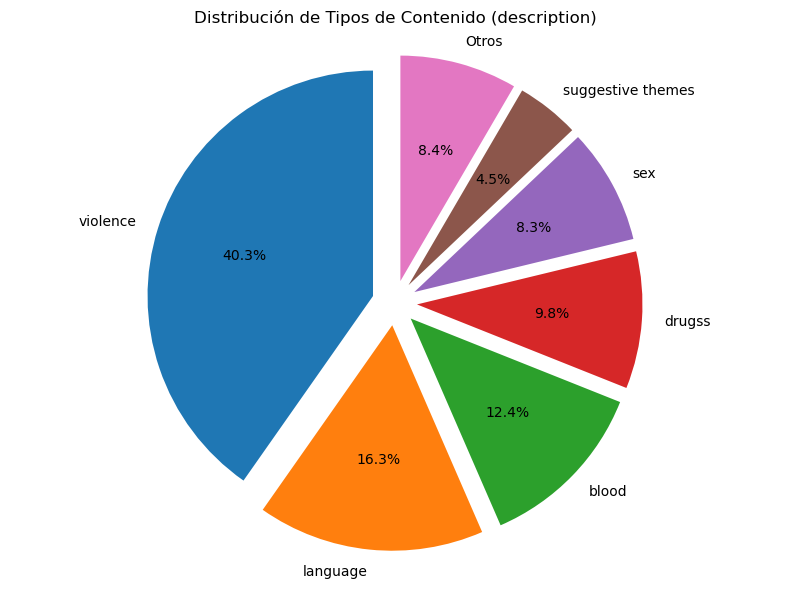

None


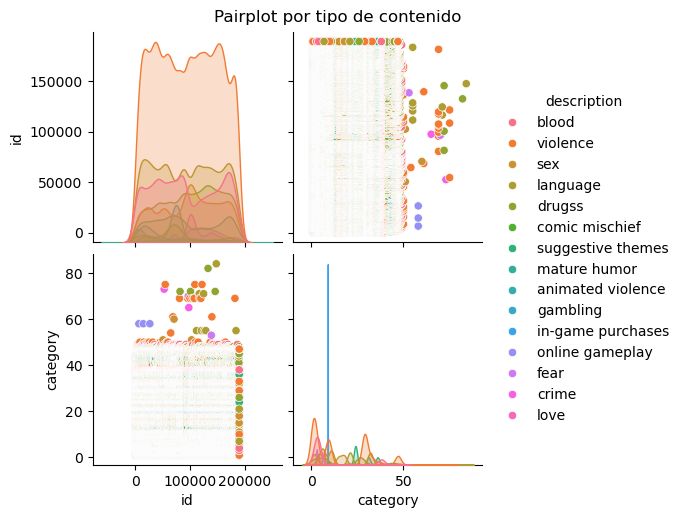

None


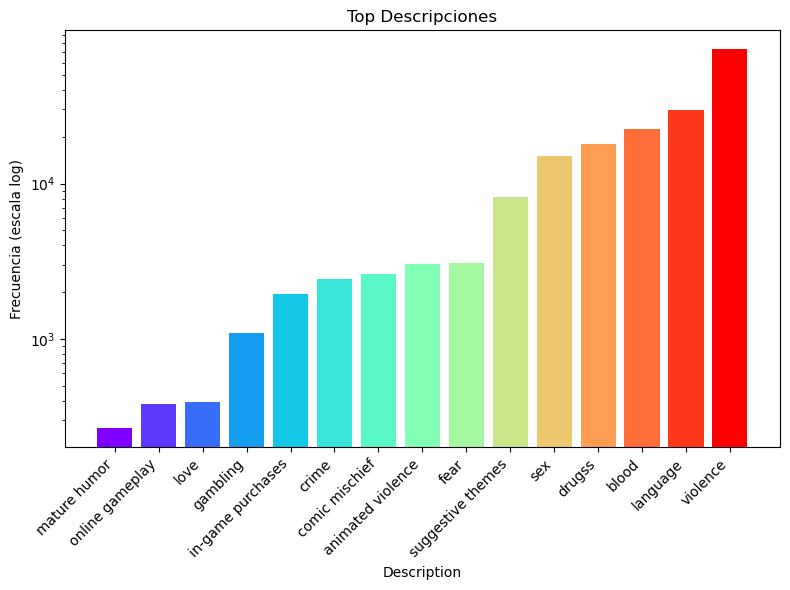

None


In [ ]:

class Description:
    def __init__(self, df):
        self.df = df
        self.palabras_clave = {
            'violence': [
                'violência (violence)', 'atos criminosos (criminal acts)', 'realistic violence',
                'violência extrema (extreme violence)', 'violent references', 'mild violence',
                'violence', 'sexual violence', 'verbal violence', 'fantasy violence',
                'intense violence', 'cartoon violence', 'discrimination' 
            ],
            'blood': [
                'blood', 'gore', 'blood and blood', 'realistic blood', 'mild blood', 'animated blood'
            ],
            'drugs': [
                'drogas (drugs)', 'use of drugs and drugs', 'drugs and tobacco reference',
                'drugs', 'use of drugs and tobacco', 'drugss, tobacco, drugs', 'drugs reference',
                'use of drugs', 'drug', 'alcohol', 'drugs and drugs reference',
                'drogas ilícitas (illegal drugs)', 'use of tobacco', 'tobacco reference', 'drinking/smoking',
                'drugssss', 'drugss', 'controlled substances', 'drogas lícitas (legal drugss)', 'drugss)', 'drugss and drugss reference',
                'drogas ilícitas (illegal drugss', 'drugss and drugss', 'drugss and tobacco', 'drugss, tobacco, drugss',
                'drugss reference'
            ],
            'sex': [
                'sex (sexual content)', 'sex (sex)', 'partial sex',
                'sexual content', 'sexo explícito', 'sexual themes', 'sexo', 'nudez', 'nudity',
                'sex', 'mature sex', 'strong sexual content', 'sexuality', 'mild sex',
                'conteúdo sexual', 'sex (explicit sex)', 'Sexo Explícito (Explicit Sex)', 'Sexo (Sex)', 'Sexual Violence'
            ],
            'gambling': [
                'real gambling', 'gambling', 'simulated gambling'
            ],
            'crime': [
                'crime', 'crime, anti-social'
            ],
            'language': [
                'language', 'strong language', 'mild language', 'bad language', 'linguagem imprópria (inappropriate language)',
                'languages and others', 'crude humor', 'strong lyrics', 'lyrics', 'mild lyrics', 'mature humor', 'love'
            ],
            'animated violence': [
                'animated violence', 'mild animated violence'
            ],
            'fear': [
                'fear', 'fear, horror, threatening', 'horror'
            ],
            'suggestive themes': [
                'mild suggestive themes', 'suggestive themesg'
            ],
        }

    def reemplazo(self, text):
        texto = str(text).lower()
        anterior = ''
        while texto != anterior:
            anterior = texto
            for categoria, keywords in self.palabras_clave.items():
                for palabra in sorted(keywords, key=len, reverse=True):
                    texto = re.sub(re.escape(palabra), categoria, texto)
        return texto

    def reemplazar_palabras(self):
        self.df['description'] = self.df['description'].apply(self.reemplazo)

    def graficar_torta(self, umbral=0.03):
        conteo_relativo = self.df['description'].value_counts(normalize=True)

        categorias_principales = conteo_relativo[conteo_relativo >= umbral]
        categorias_otros = conteo_relativo[conteo_relativo < umbral]

        datos = categorias_principales.copy()
        if not categorias_otros.empty:
            datos['Otros'] = categorias_otros.sum()

        datos_abs = datos * len(self.df)
        etiquetas = [f'{cat}' for cat in datos.index]
        valores = datos_abs.values

        fig, axs = plt.subplots(1, 2 if not categorias_otros.empty else 1, figsize=(12, 6))

        ax1 = axs[0] if not categorias_otros.empty else axs
        wedges, texts, autotexts = ax1.pie(
            valores,
            autopct='%1.1f%%',
            startangle=90,
            explode=[0.08] * len(datos),
        )
        ax1.legend(wedges, etiquetas, title="Categorías", loc="best", bbox_to_anchor=(1, 0.5))

        if not categorias_otros.empty:
            datos_otros_abs = categorias_otros * len(self.df)
            etiquetas_otros = [f'{cat}' for cat in categorias_otros.index]
            valores_otros = datos_otros_abs.values

            ax2 = axs[1]
            wedges2, texts2, autotexts2 = ax2.pie(
                valores_otros,
                autopct='%1.1f%%',
                startangle=90,
                explode=[0.08] * len(categorias_otros),
                pctdistance=0.85,
            )
            ax2.legend(wedges2, etiquetas_otros, title="Otros", loc="best", bbox_to_anchor=(1, 0.5))

        plt.tight_layout()
        plt.show()

    def graficar_barras_arcoiris(self, columna='description', titulo="Gráfico de Barras", ordenar=True):
        conteo = self.df[columna].value_counts()

        if ordenar:
            conteo = conteo.sort_values(ascending=True)

        categorias = conteo.index
        valores = conteo.values

        colores = plt.cm.rainbow(np.linspace(0, 1, len(categorias)))

        plt.figure(figsize=(10, 6))
        plt.bar(categorias, valores, color=colores)  
        plt.title(titulo)
        plt.xlabel("Frecuencia")
        plt.ylabel(columna.capitalize())
        plt.tight_layout()
        plt.xticks(rotation=45, ha='right')
        plt.show()
        
description = Description(df_unido)
description.reemplazar_palabras()
description.graficar_torta()
description.graficar_barras_arcoiris()